## Changes made for the 2nd submission based on the reviewer guide:
1. I added deep layers in both generator and discriminator
2. I added the learning_rate to the feed_dict
3. I used Xavier initializer
4. I tried to reduce the beta1 decay to .4 and .3
5. I increased the z_dim for the CelebA images to be 512
 

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [104]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

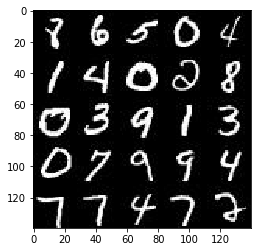

In [105]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

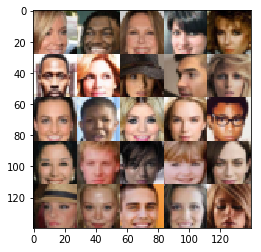

In [106]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [107]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0


/Users/shakiralharthi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [108]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width,image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32,[None, z_dim], name='z_input')
    lr = tf.placeholder(tf.float32, name= 'lr')

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [109]:
#set alpha 

alpha = .2

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [202]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    #print(images.shape)
    with tf.variable_scope('discriminator',reuse=reuse):
        x = tf.layers.conv2d(inputs=images, filters = 32 , kernel_size= 5, strides= 2 ,  padding='same',activation= None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        relul = tf.maximum(x * alpha, x)
        
   
        #now shape is 14*14*32
        
        x2 = tf.layers.conv2d(relul, filters = 64, kernel_size= 5, strides=2, padding = 'same',activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training= True)
        relul2 = tf.maximum(x2 * alpha, x2)
        #relul2 = tf.layers.dropout(relul2,rate=.8)
        
        # Now shape is 7*7*64

        x3 =  tf.layers.conv2d(relul2, filters = 128, kernel_size= 5, strides=1, padding = 'same',activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 =  tf.layers.batch_normalization(x3, training= True)
        relul3 = tf.maximum(x3 * alpha, x3)
        #relul3 = tf.layers.dropout(relul3,rate=.8)
        #print(relul3.shape)
        
        x4 =  tf.layers.conv2d(relul3, filters = 256, kernel_size= 5, strides=2, padding = 'same',activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 =  tf.layers.batch_normalization(x4, training= True)
        relul4 = tf.maximum(x4 * alpha, x4)
        #print('relul4  =',relul4.shape)
        

        
        flat = tf.reshape(relul4, (-1, 4*4*256))
        
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
        
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [195]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
   
    # TODO: Implement Function

    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse = reuse):
        
        x1= tf.layers.dense(z,2*2*1024, kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print(x1.shape)
        x1= tf.reshape(z, (-1, 2,2,1024))
        #x1= tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        #print (x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 512,5, strides=2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 256,5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        x4 = tf.layers.conv2d_transpose(x3, 128,5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #print(x4.shape)
        
        
        

        
        #print(out_channel_dim)
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x
        
        #print(logits.shape, 'logits shape')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [114]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    d_output_real, d_logit_real = discriminator(input_real, reuse= False)
    d_output_fake, d_logit_fake = discriminator(g_output, reuse= True)
    
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake, labels=tf.zeros_like(d_output_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_fake,labels = tf.ones_like(d_output_fake)))
    
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [115]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [122]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-.5, .5, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [207]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
  

    
    #print(data_shape)
    step = 0
    real_input,z_input,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #print(batch_images.shape)
                step += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-.5,.5 , size=(batch_size, z_dim))

                #print('batch_z shape',batch_z.shape)
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {real_input: batch_images, z_input: batch_z,lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {z_input: batch_z, real_input: batch_images, lr: learning_rate})

                if step % 90 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
               
                    show_generator_output(sess,32, z_input, data_shape[3], data_image_mode)
    
                   
                


The reviewer asked for setting n_images not more than 25 when calling the method:
>show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)

However the number is not optional for setting. When ever I set the n_images number, it will be multiplied by the z_dim. and pushed to the generator.
The generator eventually will reshape the coming product ( n_images * z_dim ) into the following :
> x1= tf.reshape(z, (-1, 2,2,1024))

so what ever is reaching to the generator will be reshaped in the multiple of 4096
Hence, I can't set the number as I wish.

I have to manage to make the n_images multiplied by z_dim exactly a multiple of the 4096

this is why I created the following fucnction to find numbers between 1-100 searching for suitable number

In [206]:
def findMultiple(x, z_dim):
    for i in range(1,100):
        r = i * z_dim
        
        if r % x == 0:
            print ('n_image : ', i,'--- multiple of ',x ,' = ', r)
           
        
print( 'searching for  number when z_dim is 128')
findMultiple(4096, 128)
print( '\n\nsearching for  number when z_dim is 512')
findMultiple(4096, 512)

searching for  number when z_dim is 128
n_image :  32 --- multiple of  4096  =  4096
n_image :  64 --- multiple of  4096  =  8192
n_image :  96 --- multiple of  4096  =  12288


searching for  number when z_dim is 512
n_image :  8 --- multiple of  4096  =  4096
n_image :  16 --- multiple of  4096  =  8192
n_image :  24 --- multiple of  4096  =  12288
n_image :  32 --- multiple of  4096  =  16384
n_image :  40 --- multiple of  4096  =  20480
n_image :  48 --- multiple of  4096  =  24576
n_image :  56 --- multiple of  4096  =  28672
n_image :  64 --- multiple of  4096  =  32768
n_image :  72 --- multiple of  4096  =  36864
n_image :  80 --- multiple of  4096  =  40960
n_image :  88 --- multiple of  4096  =  45056
n_image :  96 --- multiple of  4096  =  49152


### Below I will try the model on multiple different hyperparameter values on the MNIST images 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
Epoch 1/4... Discriminator Loss: 0.0811... Generator Loss: 3.0263


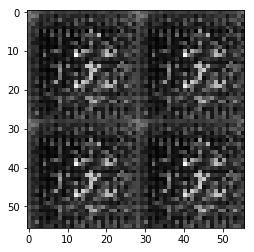

Epoch 1/4... Discriminator Loss: 0.9552... Generator Loss: 2.3263


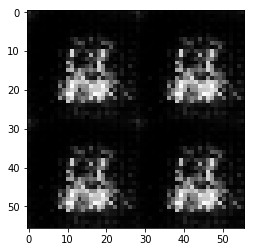

Epoch 1/4... Discriminator Loss: 0.2749... Generator Loss: 1.9327


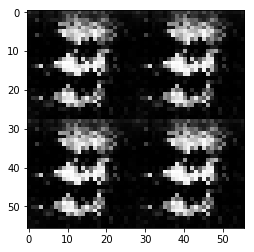

Epoch 1/4... Discriminator Loss: 0.1234... Generator Loss: 2.8740


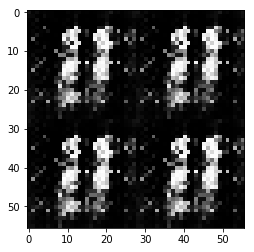

Epoch 1/4... Discriminator Loss: 0.0802... Generator Loss: 3.1067


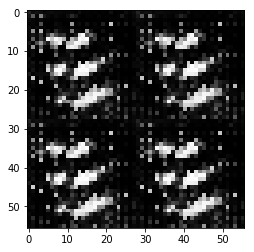

Epoch 2/4... Discriminator Loss: 0.0588... Generator Loss: 3.5850


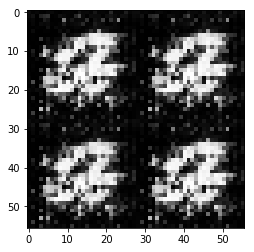

Epoch 2/4... Discriminator Loss: 0.1017... Generator Loss: 3.1175


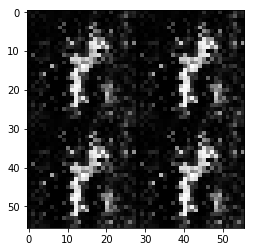

Epoch 2/4... Discriminator Loss: 0.0739... Generator Loss: 2.7459


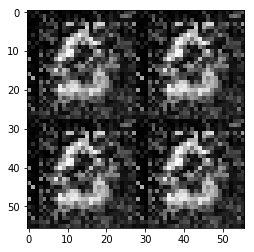

Epoch 2/4... Discriminator Loss: 0.1074... Generator Loss: 2.6596


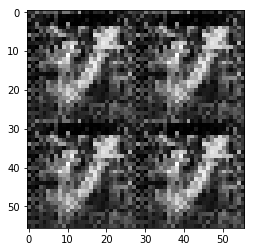

Epoch 2/4... Discriminator Loss: 0.9717... Generator Loss: 7.9977


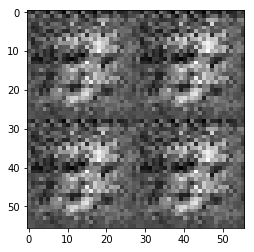

Epoch 3/4... Discriminator Loss: 0.2717... Generator Loss: 2.3339


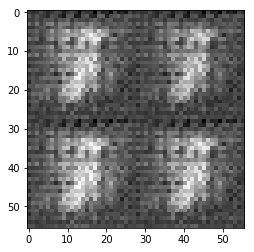

Epoch 3/4... Discriminator Loss: 0.2367... Generator Loss: 2.3722


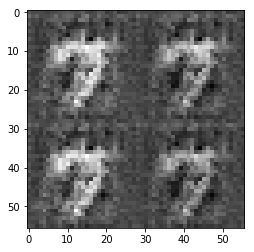

Epoch 3/4... Discriminator Loss: 0.2204... Generator Loss: 2.4523


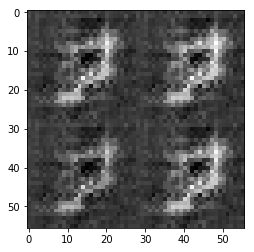

Epoch 3/4... Discriminator Loss: 0.2687... Generator Loss: 6.4704


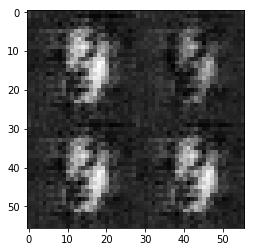

Epoch 3/4... Discriminator Loss: 0.2123... Generator Loss: 2.0635


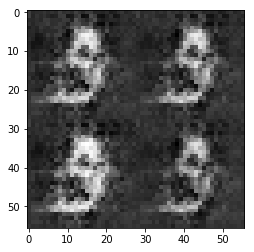

Epoch 4/4... Discriminator Loss: 0.1740... Generator Loss: 3.8972


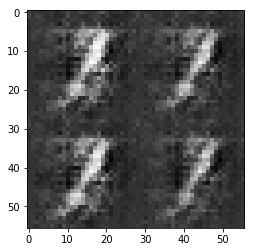

Epoch 4/4... Discriminator Loss: 0.2555... Generator Loss: 1.6717


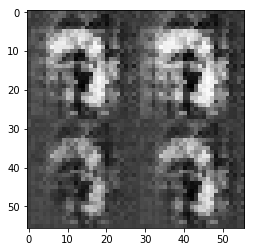

Epoch 4/4... Discriminator Loss: 0.2183... Generator Loss: 5.7273


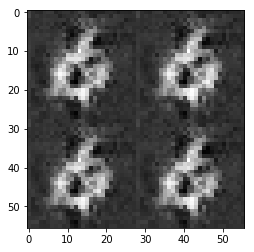

Epoch 4/4... Discriminator Loss: 0.1702... Generator Loss: 2.5392


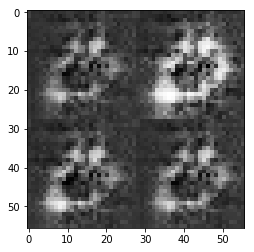

Epoch 4/4... Discriminator Loss: 0.0377... Generator Loss: 4.3991


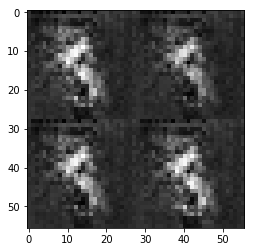

finsihed


In [198]:
batch_size =128
z_dim = 128
learning_rate = 0.0001
beta1 = .5
alpha= .2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
Epoch 1/5... Discriminator Loss: 2.3983... Generator Loss: 0.1373


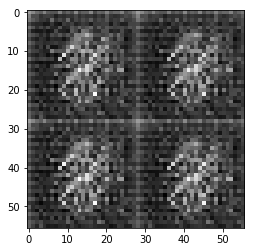

Epoch 1/5... Discriminator Loss: 0.2453... Generator Loss: 2.2583


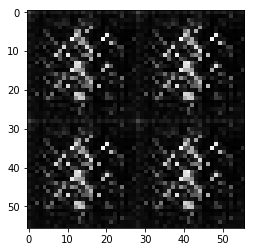

Epoch 1/5... Discriminator Loss: 0.2361... Generator Loss: 2.0062


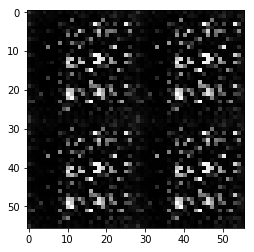

Epoch 1/5... Discriminator Loss: 0.1462... Generator Loss: 2.8002


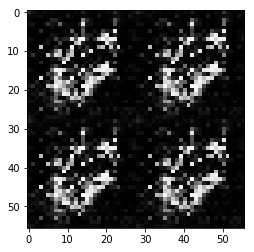

Epoch 1/5... Discriminator Loss: 0.0669... Generator Loss: 3.2204


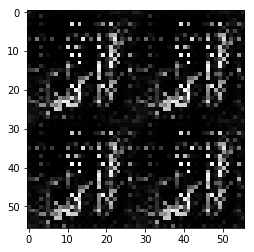

Epoch 2/5... Discriminator Loss: 0.1508... Generator Loss: 2.4038


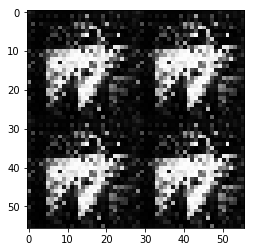

Epoch 2/5... Discriminator Loss: 0.0759... Generator Loss: 3.3834


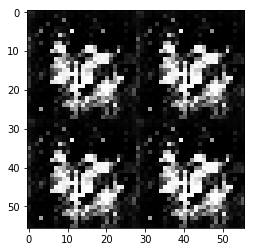

Epoch 2/5... Discriminator Loss: 0.0746... Generator Loss: 3.7556


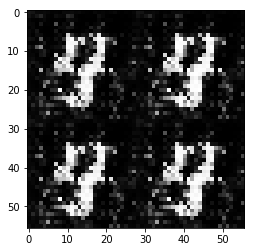

Epoch 2/5... Discriminator Loss: 0.0702... Generator Loss: 3.7541


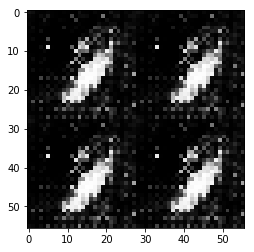

Epoch 2/5... Discriminator Loss: 0.0460... Generator Loss: 3.7477


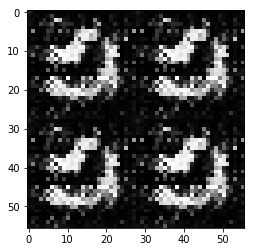

Epoch 3/5... Discriminator Loss: 0.0695... Generator Loss: 3.1280


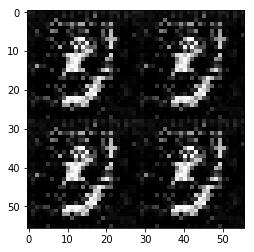

Epoch 3/5... Discriminator Loss: 0.0253... Generator Loss: 4.2860


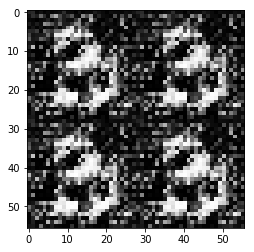

Epoch 3/5... Discriminator Loss: 0.5542... Generator Loss: 4.6680


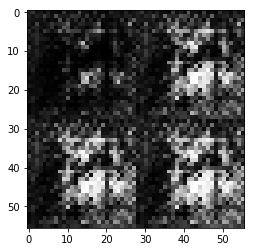

Epoch 3/5... Discriminator Loss: 0.1557... Generator Loss: 9.2258


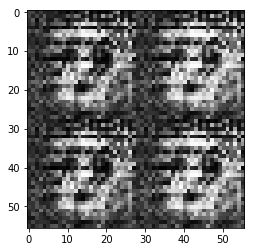

Epoch 3/5... Discriminator Loss: 1.5867... Generator Loss: 0.2679


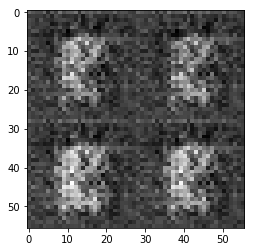

Epoch 4/5... Discriminator Loss: 1.1781... Generator Loss: 0.3950


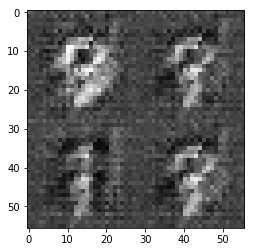

Epoch 4/5... Discriminator Loss: 0.3088... Generator Loss: 2.3297


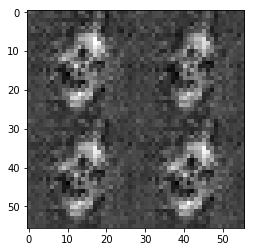

Epoch 4/5... Discriminator Loss: 0.5608... Generator Loss: 1.1109


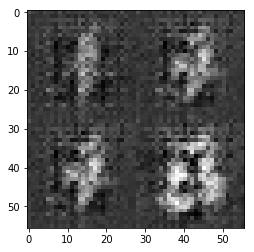

Epoch 4/5... Discriminator Loss: 0.2150... Generator Loss: 2.3750


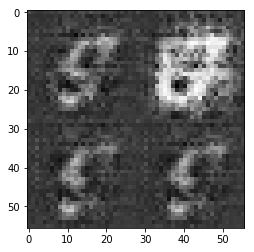

Epoch 4/5... Discriminator Loss: 0.0655... Generator Loss: 4.0049


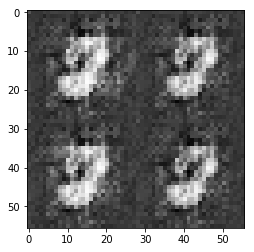

Epoch 5/5... Discriminator Loss: 0.2400... Generator Loss: 4.7074


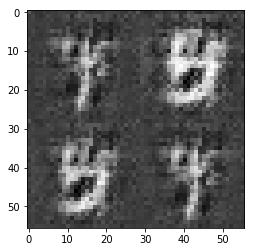

Epoch 5/5... Discriminator Loss: 0.2625... Generator Loss: 3.2198


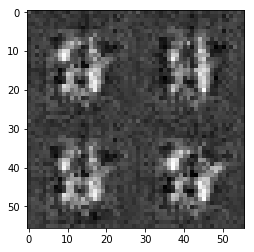

Epoch 5/5... Discriminator Loss: 0.4178... Generator Loss: 1.4423


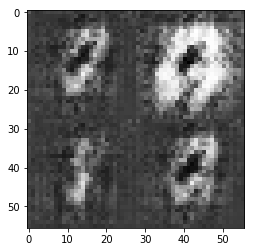

Epoch 5/5... Discriminator Loss: 0.0412... Generator Loss: 4.9254


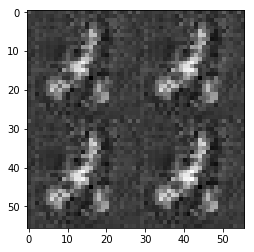

Epoch 5/5... Discriminator Loss: 0.2616... Generator Loss: 2.0175


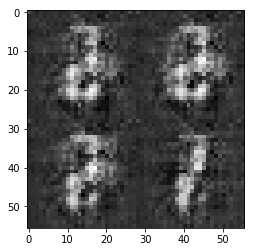

Epoch 5/5... Discriminator Loss: 0.2678... Generator Loss: 1.7968


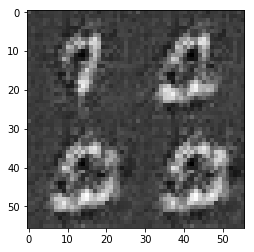

finsihed


In [199]:
batch_size =128
z_dim = 128
learning_rate = 0.0001
beta1 = .3
alpha= .2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
Epoch 1/3... Discriminator Loss: 1.0610... Generator Loss: 0.7537


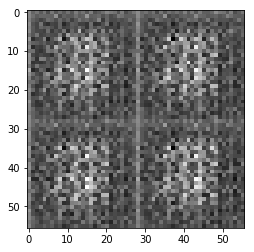

Epoch 1/3... Discriminator Loss: 0.5115... Generator Loss: 1.5036


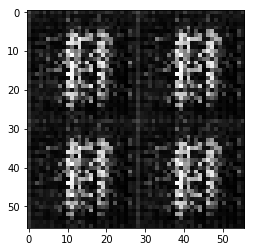

Epoch 1/3... Discriminator Loss: 0.2368... Generator Loss: 2.0849


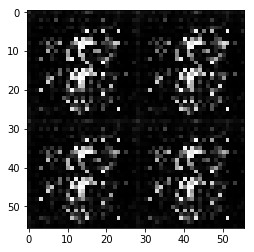

Epoch 1/3... Discriminator Loss: 0.2337... Generator Loss: 1.9012


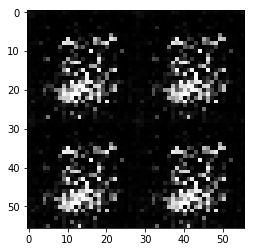

Epoch 2/3... Discriminator Loss: 0.1194... Generator Loss: 2.7565


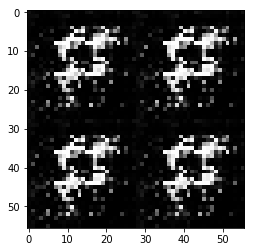

Epoch 2/3... Discriminator Loss: 0.1388... Generator Loss: 2.4343


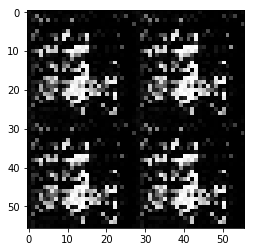

Epoch 2/3... Discriminator Loss: 0.0765... Generator Loss: 3.3805


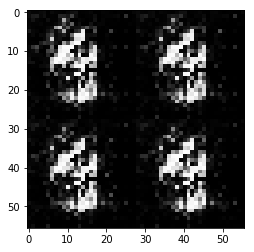

Epoch 2/3... Discriminator Loss: 0.1186... Generator Loss: 2.6147


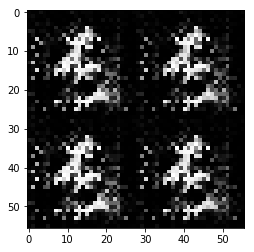

Epoch 3/3... Discriminator Loss: 0.0311... Generator Loss: 3.9495


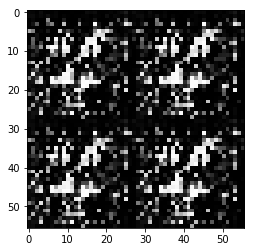

Epoch 3/3... Discriminator Loss: 0.0673... Generator Loss: 3.2116


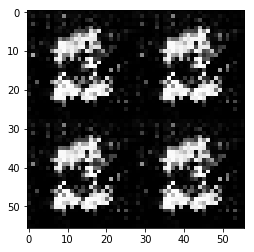

Epoch 3/3... Discriminator Loss: 0.0532... Generator Loss: 3.4254


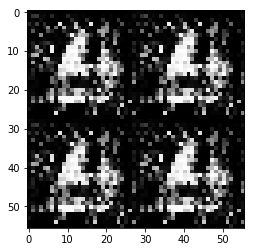

Epoch 3/3... Discriminator Loss: 0.0197... Generator Loss: 4.3922


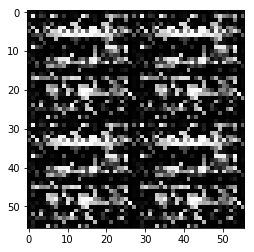

finsihed


In [185]:
batch_size =160
z_dim = 128
learning_rate = 0.00005
beta1 = .3
alpha= .2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

Epoch 1/3... Discriminator Loss: 2.6484... Generator Loss: 3.3406


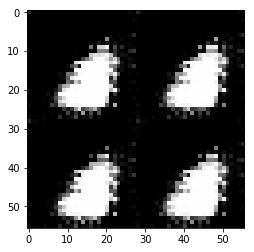

Epoch 1/3... Discriminator Loss: 0.1142... Generator Loss: 3.2461


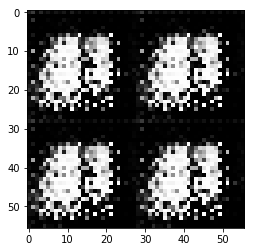

Epoch 1/3... Discriminator Loss: 0.0494... Generator Loss: 3.5951


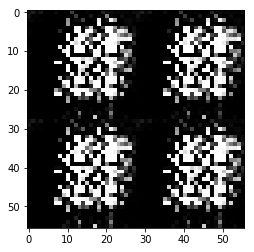

Epoch 1/3... Discriminator Loss: 0.1086... Generator Loss: 3.1005


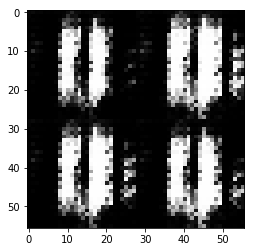

Epoch 2/3... Discriminator Loss: 0.0139... Generator Loss: 4.7190


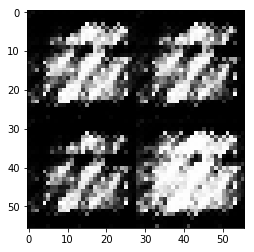

Epoch 2/3... Discriminator Loss: 0.0362... Generator Loss: 4.1505


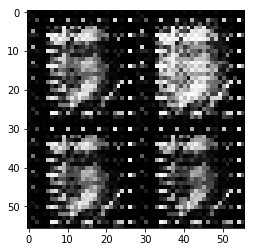

Epoch 2/3... Discriminator Loss: 0.9350... Generator Loss: 0.5292


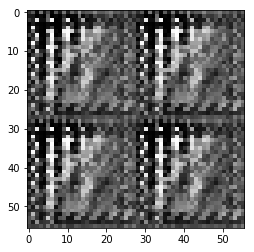

Epoch 2/3... Discriminator Loss: 1.2522... Generator Loss: 0.5776


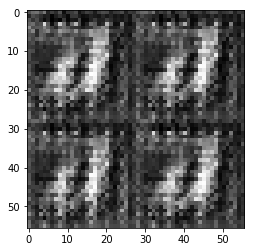

Epoch 3/3... Discriminator Loss: 0.0185... Generator Loss: 6.6078


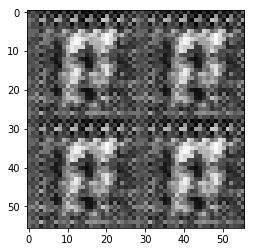

Epoch 3/3... Discriminator Loss: 0.1467... Generator Loss: 6.4626


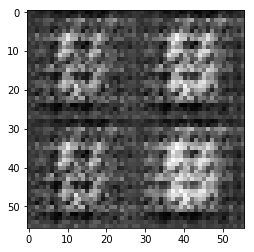

Epoch 3/3... Discriminator Loss: 0.0640... Generator Loss: 7.6540


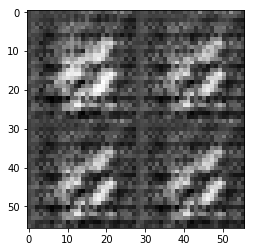

Epoch 3/3... Discriminator Loss: 0.1006... Generator Loss: 2.9326


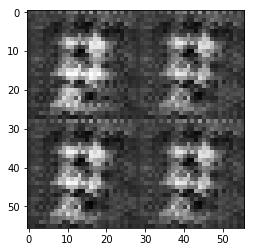

finsihed


In [203]:
batch_size =160
z_dim = 128
learning_rate = 0.001
beta1 = .5
alpha= .2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

Epoch 1/3... Discriminator Loss: 0.6466... Generator Loss: 0.7776


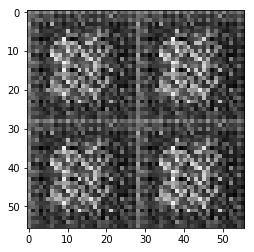

Epoch 1/3... Discriminator Loss: 3.4877... Generator Loss: 0.0374


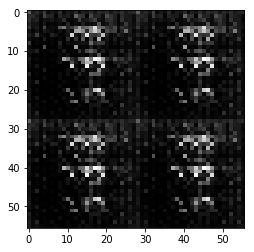

Epoch 1/3... Discriminator Loss: 0.2148... Generator Loss: 2.3571


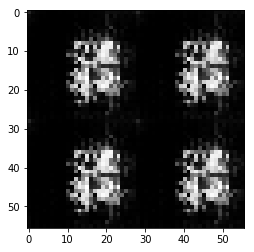

Epoch 1/3... Discriminator Loss: 0.1840... Generator Loss: 2.6566


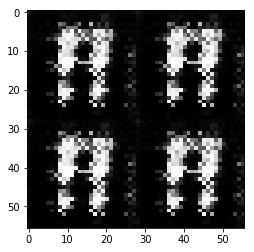

Epoch 2/3... Discriminator Loss: 0.0899... Generator Loss: 3.1059


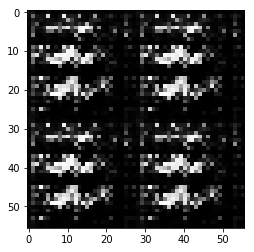

Epoch 2/3... Discriminator Loss: 0.0612... Generator Loss: 3.3144


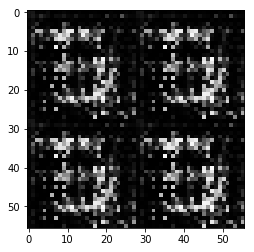

Epoch 2/3... Discriminator Loss: 0.1164... Generator Loss: 2.4531


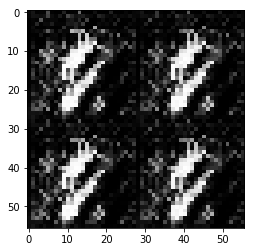

Epoch 2/3... Discriminator Loss: 0.1058... Generator Loss: 2.8405


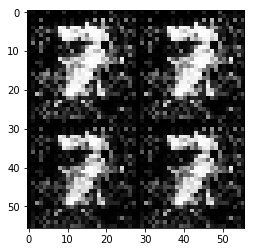

Epoch 3/3... Discriminator Loss: 0.0561... Generator Loss: 4.0390


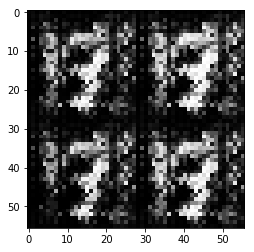

Epoch 3/3... Discriminator Loss: 0.0414... Generator Loss: 4.3739


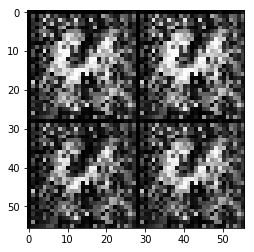

Epoch 3/3... Discriminator Loss: 0.5726... Generator Loss: 0.9168


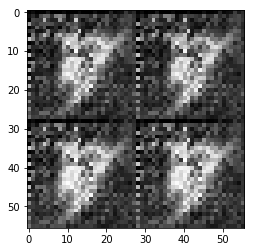

Epoch 3/3... Discriminator Loss: 2.0783... Generator Loss: 0.1439


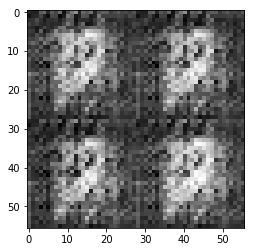

finsihed


In [204]:
batch_size =160
z_dim = 128
learning_rate = 0.0001
beta1 = .4
alpha= .3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('finsihed')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
(?, 7, 7, 128)
relul4  = (?, 4, 4, 256)
Epoch 1/3... Discriminator Loss: 0.5394... Generator Loss: 1.5792


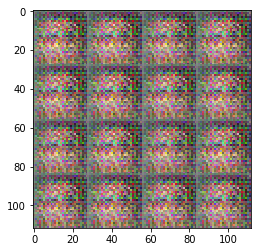

Epoch 1/3... Discriminator Loss: 0.3088... Generator Loss: 2.2121


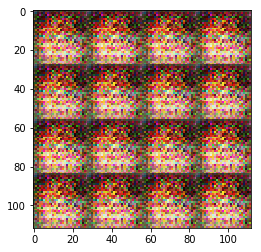

Epoch 1/3... Discriminator Loss: 0.1079... Generator Loss: 3.0249


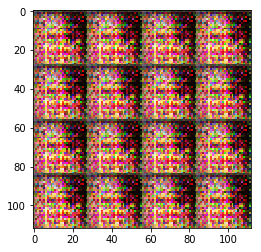

Epoch 1/3... Discriminator Loss: 0.0521... Generator Loss: 3.8133


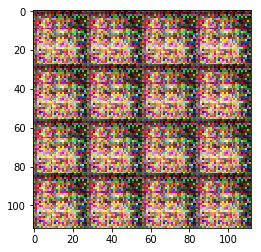

Epoch 1/3... Discriminator Loss: 0.0324... Generator Loss: 4.4740


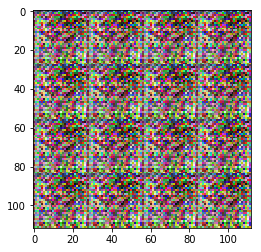

Epoch 1/3... Discriminator Loss: 0.0449... Generator Loss: 3.8662


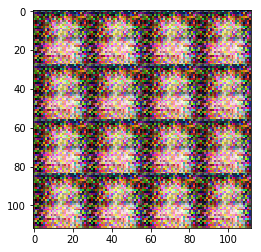

Epoch 1/3... Discriminator Loss: 0.0226... Generator Loss: 4.7189


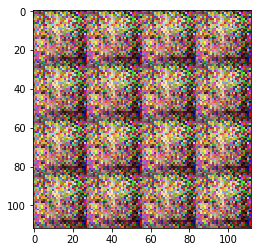

Epoch 1/3... Discriminator Loss: 0.0147... Generator Loss: 5.0102


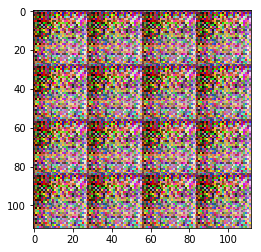

Epoch 1/3... Discriminator Loss: 1.0767... Generator Loss: 0.6830


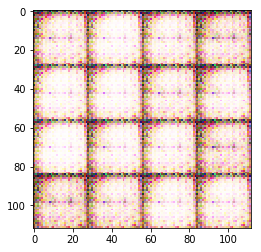

Epoch 1/3... Discriminator Loss: 0.4766... Generator Loss: 1.7690


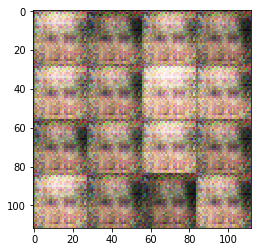

Epoch 1/3... Discriminator Loss: 1.0944... Generator Loss: 1.1987


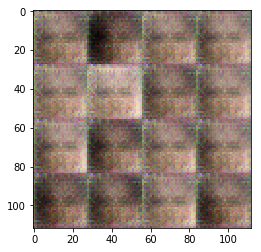

Epoch 1/3... Discriminator Loss: 0.2358... Generator Loss: 2.1020


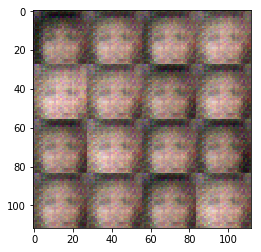

Epoch 1/3... Discriminator Loss: 0.3266... Generator Loss: 2.0573


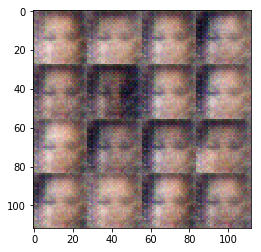

Epoch 1/3... Discriminator Loss: 1.0782... Generator Loss: 0.5851


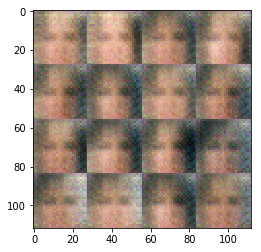

Epoch 2/3... Discriminator Loss: 0.3799... Generator Loss: 1.5987


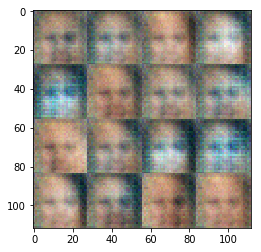

Epoch 2/3... Discriminator Loss: 0.0474... Generator Loss: 6.0741


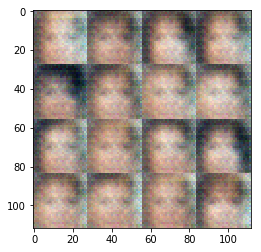

Epoch 2/3... Discriminator Loss: 0.4625... Generator Loss: 1.4032


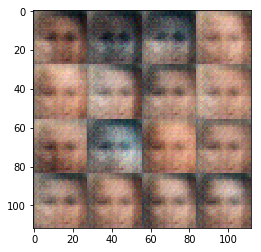

Epoch 2/3... Discriminator Loss: 0.6974... Generator Loss: 0.9033


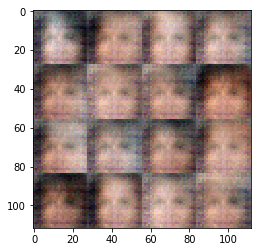

Epoch 2/3... Discriminator Loss: 1.0641... Generator Loss: 0.5773


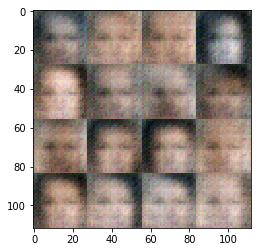

Epoch 2/3... Discriminator Loss: 0.0803... Generator Loss: 3.5129


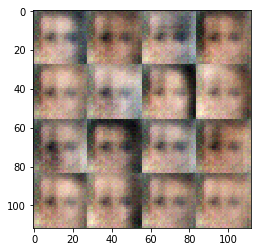

Epoch 2/3... Discriminator Loss: 0.0715... Generator Loss: 4.7314


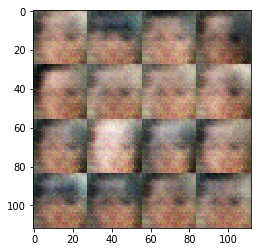

Epoch 2/3... Discriminator Loss: 0.1184... Generator Loss: 3.3190


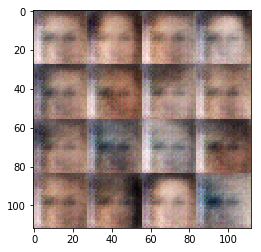

Epoch 2/3... Discriminator Loss: 2.1866... Generator Loss: 0.1963


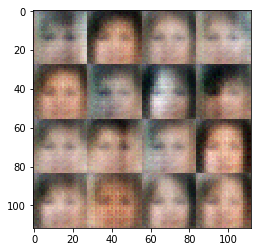

Epoch 2/3... Discriminator Loss: 0.7011... Generator Loss: 0.9453


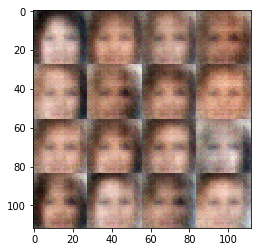

Epoch 2/3... Discriminator Loss: 0.0635... Generator Loss: 7.0700


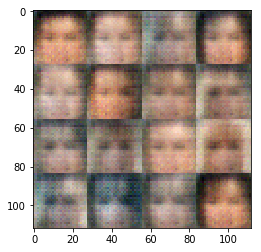

Epoch 2/3... Discriminator Loss: 0.3318... Generator Loss: 2.0595


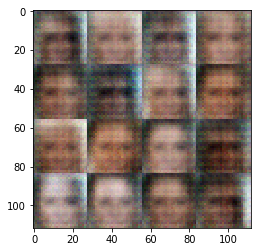

Epoch 2/3... Discriminator Loss: 0.0637... Generator Loss: 5.3308


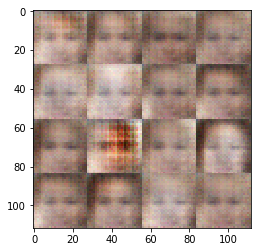

Epoch 2/3... Discriminator Loss: 0.8245... Generator Loss: 0.7125


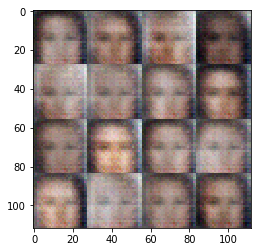

Epoch 3/3... Discriminator Loss: 0.5429... Generator Loss: 1.3851


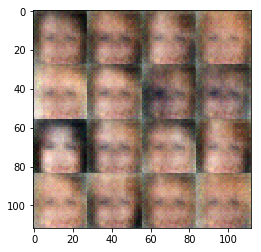

Epoch 3/3... Discriminator Loss: 0.0942... Generator Loss: 3.6340


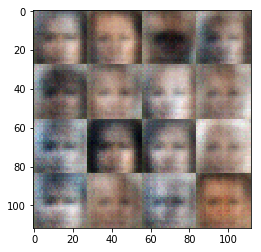

Epoch 3/3... Discriminator Loss: 0.0268... Generator Loss: 4.7674


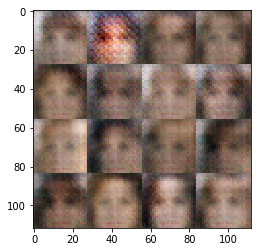

Epoch 3/3... Discriminator Loss: 0.3687... Generator Loss: 1.5570


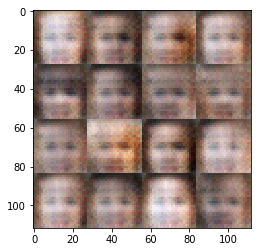

Epoch 3/3... Discriminator Loss: 0.6966... Generator Loss: 0.9329


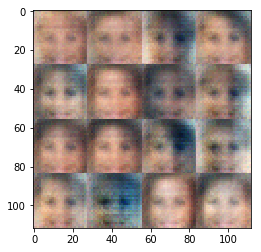

Epoch 3/3... Discriminator Loss: 0.0167... Generator Loss: 5.6495


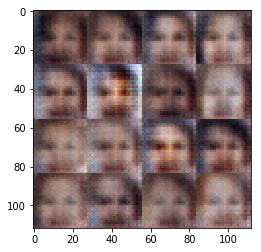

Epoch 3/3... Discriminator Loss: 0.3750... Generator Loss: 1.5949


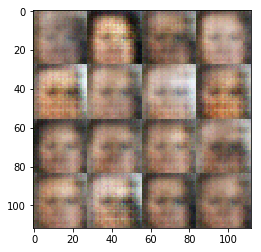

Epoch 3/3... Discriminator Loss: 1.9015... Generator Loss: 0.2138


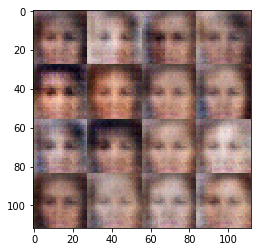

Epoch 3/3... Discriminator Loss: 0.1915... Generator Loss: 2.4844


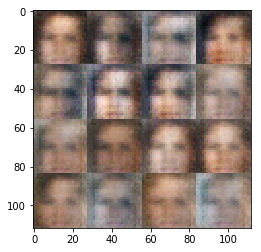

Epoch 3/3... Discriminator Loss: 0.8811... Generator Loss: 0.7510


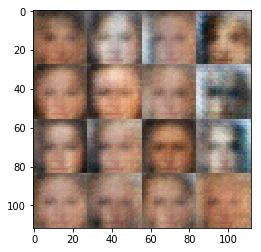

Epoch 3/3... Discriminator Loss: 0.2030... Generator Loss: 9.5917


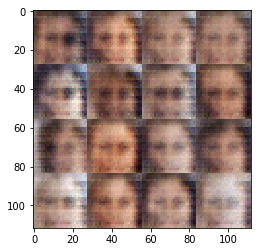

Epoch 3/3... Discriminator Loss: 0.1828... Generator Loss: 2.2986


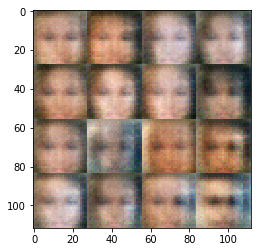

Epoch 3/3... Discriminator Loss: 0.0627... Generator Loss: 5.0162


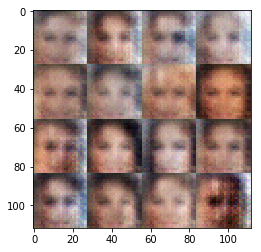

Epoch 3/3... Discriminator Loss: 0.0551... Generator Loss: 5.1804


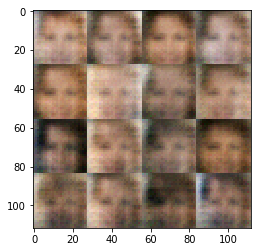

finished


In [200]:
batch_size = 160
z_dim = 512
learning_rate = .0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    
    
print('finished')

Epoch 1/3... Discriminator Loss: 0.5296... Generator Loss: 1.8184


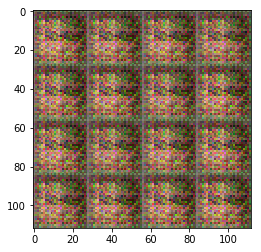

Epoch 1/3... Discriminator Loss: 0.2808... Generator Loss: 2.1528


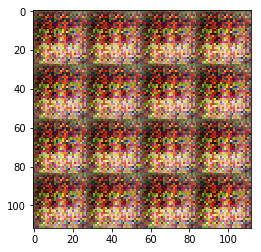

Epoch 1/3... Discriminator Loss: 0.1193... Generator Loss: 3.1477


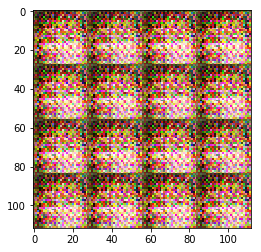

Epoch 1/3... Discriminator Loss: 0.0787... Generator Loss: 3.3103


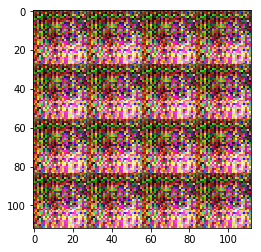

Epoch 1/3... Discriminator Loss: 0.0266... Generator Loss: 4.0434


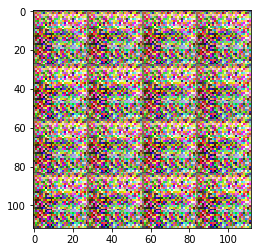

Epoch 1/3... Discriminator Loss: 0.0344... Generator Loss: 3.9047


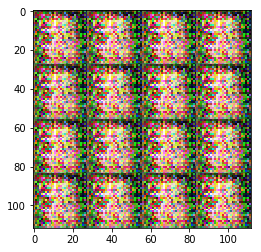

Epoch 1/3... Discriminator Loss: 0.0461... Generator Loss: 3.7601


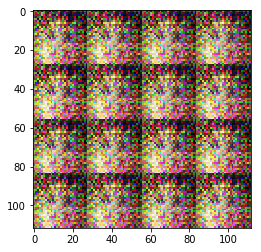

Epoch 1/3... Discriminator Loss: 1.4658... Generator Loss: 0.3592


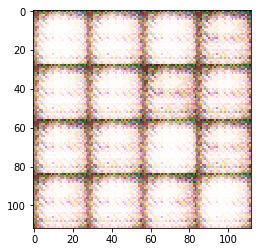

Epoch 1/3... Discriminator Loss: 0.4758... Generator Loss: 4.5221


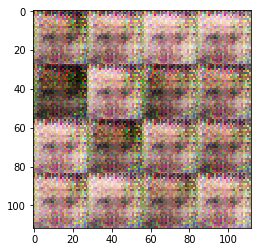

Epoch 1/3... Discriminator Loss: 0.3889... Generator Loss: 1.8333


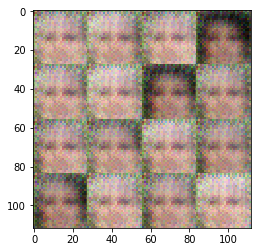

Epoch 1/3... Discriminator Loss: 2.3614... Generator Loss: 0.1131


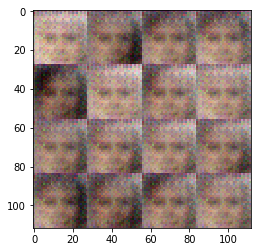

Epoch 1/3... Discriminator Loss: 0.0470... Generator Loss: 4.8753


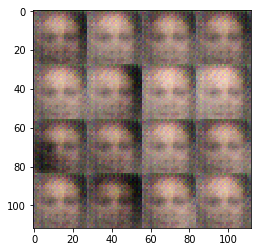

Epoch 1/3... Discriminator Loss: 0.7439... Generator Loss: 0.7996


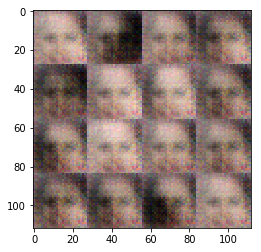

Epoch 1/3... Discriminator Loss: 1.1502... Generator Loss: 0.5095


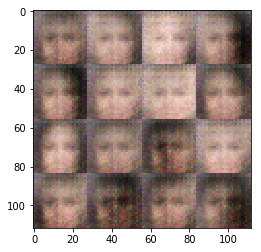

Epoch 2/3... Discriminator Loss: 0.2895... Generator Loss: 2.4216


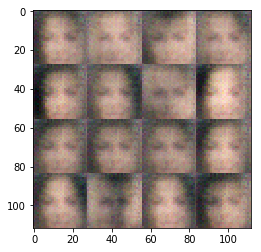

Epoch 2/3... Discriminator Loss: 0.5811... Generator Loss: 11.1422


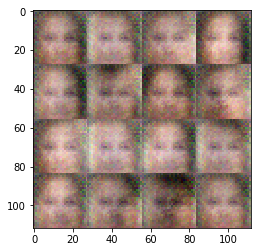

Epoch 2/3... Discriminator Loss: 0.0668... Generator Loss: 5.4736


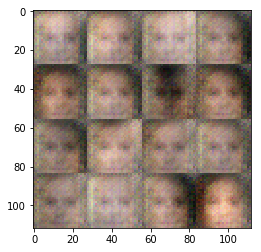

Epoch 2/3... Discriminator Loss: 0.0901... Generator Loss: 3.3743


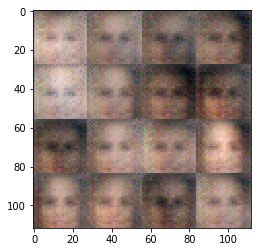

Epoch 2/3... Discriminator Loss: 0.5271... Generator Loss: 1.1673


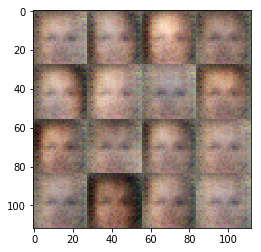

Epoch 2/3... Discriminator Loss: 0.0320... Generator Loss: 9.7654


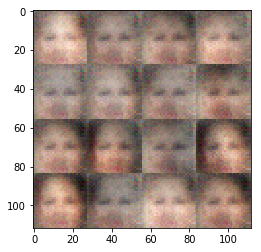

Epoch 2/3... Discriminator Loss: 0.1229... Generator Loss: 2.6189


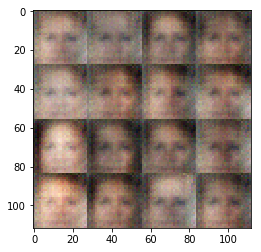

Epoch 2/3... Discriminator Loss: 0.0730... Generator Loss: 3.1984


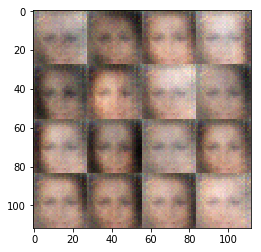

Epoch 2/3... Discriminator Loss: 3.4061... Generator Loss: 10.2748


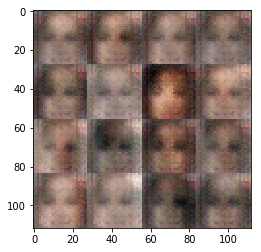

Epoch 2/3... Discriminator Loss: 0.0243... Generator Loss: 7.3599


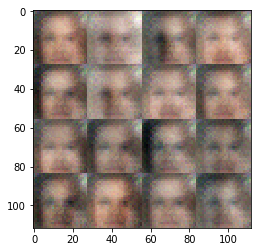

Epoch 2/3... Discriminator Loss: 0.0284... Generator Loss: 8.9709


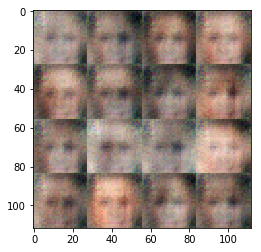

Epoch 2/3... Discriminator Loss: 0.1743... Generator Loss: 2.1719


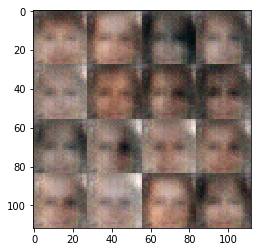

Epoch 2/3... Discriminator Loss: 1.3729... Generator Loss: 0.3569


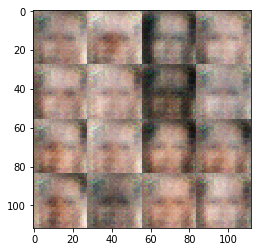

Epoch 2/3... Discriminator Loss: 0.0565... Generator Loss: 8.0124


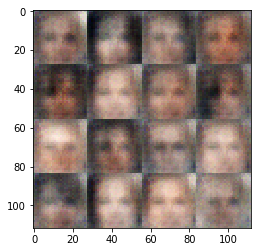

Epoch 3/3... Discriminator Loss: 0.1776... Generator Loss: 2.6301


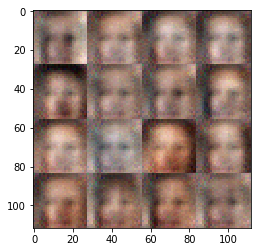

Epoch 3/3... Discriminator Loss: 0.0271... Generator Loss: 5.1616


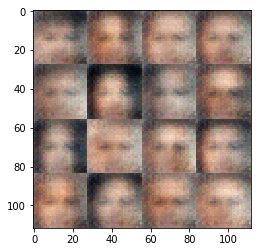

Epoch 3/3... Discriminator Loss: 0.0117... Generator Loss: 9.6208


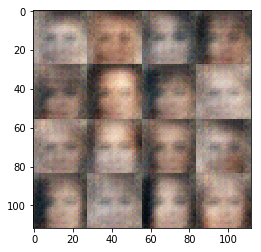

Epoch 3/3... Discriminator Loss: 0.0174... Generator Loss: 10.9493


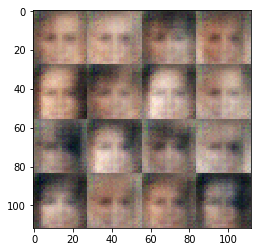

Epoch 3/3... Discriminator Loss: 2.5899... Generator Loss: 8.9279


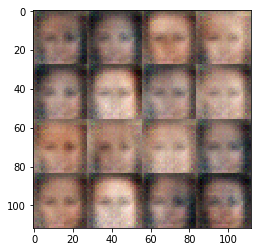

Epoch 3/3... Discriminator Loss: 0.0474... Generator Loss: 4.3912


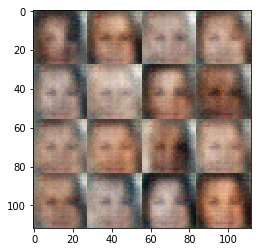

Epoch 3/3... Discriminator Loss: 0.0095... Generator Loss: 7.2704


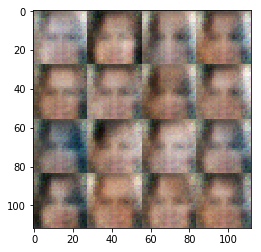

Epoch 3/3... Discriminator Loss: 0.0676... Generator Loss: 6.6771


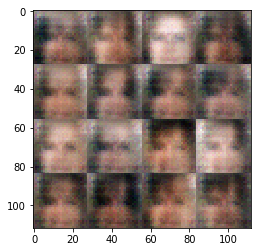

Epoch 3/3... Discriminator Loss: 0.0716... Generator Loss: 13.0990


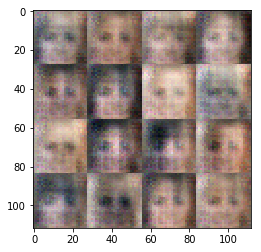

Epoch 3/3... Discriminator Loss: 0.3889... Generator Loss: 1.3434


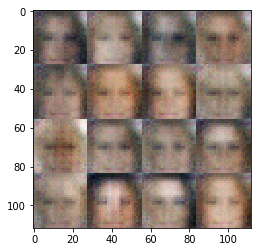

Epoch 3/3... Discriminator Loss: 0.0189... Generator Loss: 9.0066


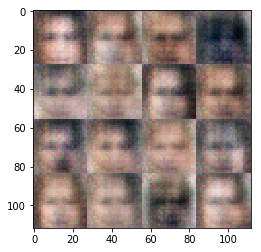

Epoch 3/3... Discriminator Loss: 0.0282... Generator Loss: 5.2139


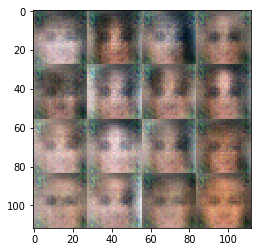

Epoch 3/3... Discriminator Loss: 0.0121... Generator Loss: 9.0402


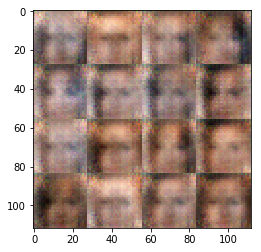

Epoch 3/3... Discriminator Loss: 0.0168... Generator Loss: 8.9210


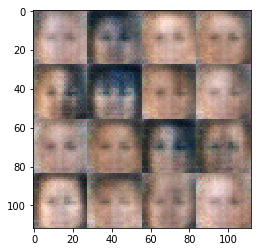

finished


In [205]:
batch_size = 160
z_dim = 512
learning_rate = .0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
    
    
print('finished')

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.